In [20]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_auc_score

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

assert x_train.shape == (50000, 32, 32, 3), 'x_train shape mismatch'
assert x_test.shape  == (10000, 32, 32, 3), 'x_test shape mismatch'
assert y_train.shape == (50000, 1),         'y_train shape mismatch'
assert y_test.shape  == (10000, 1),         'x_test shape mismatch'

classes = np.array([b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'])

170498071/170498071 [==============================] - 6s 0us/step


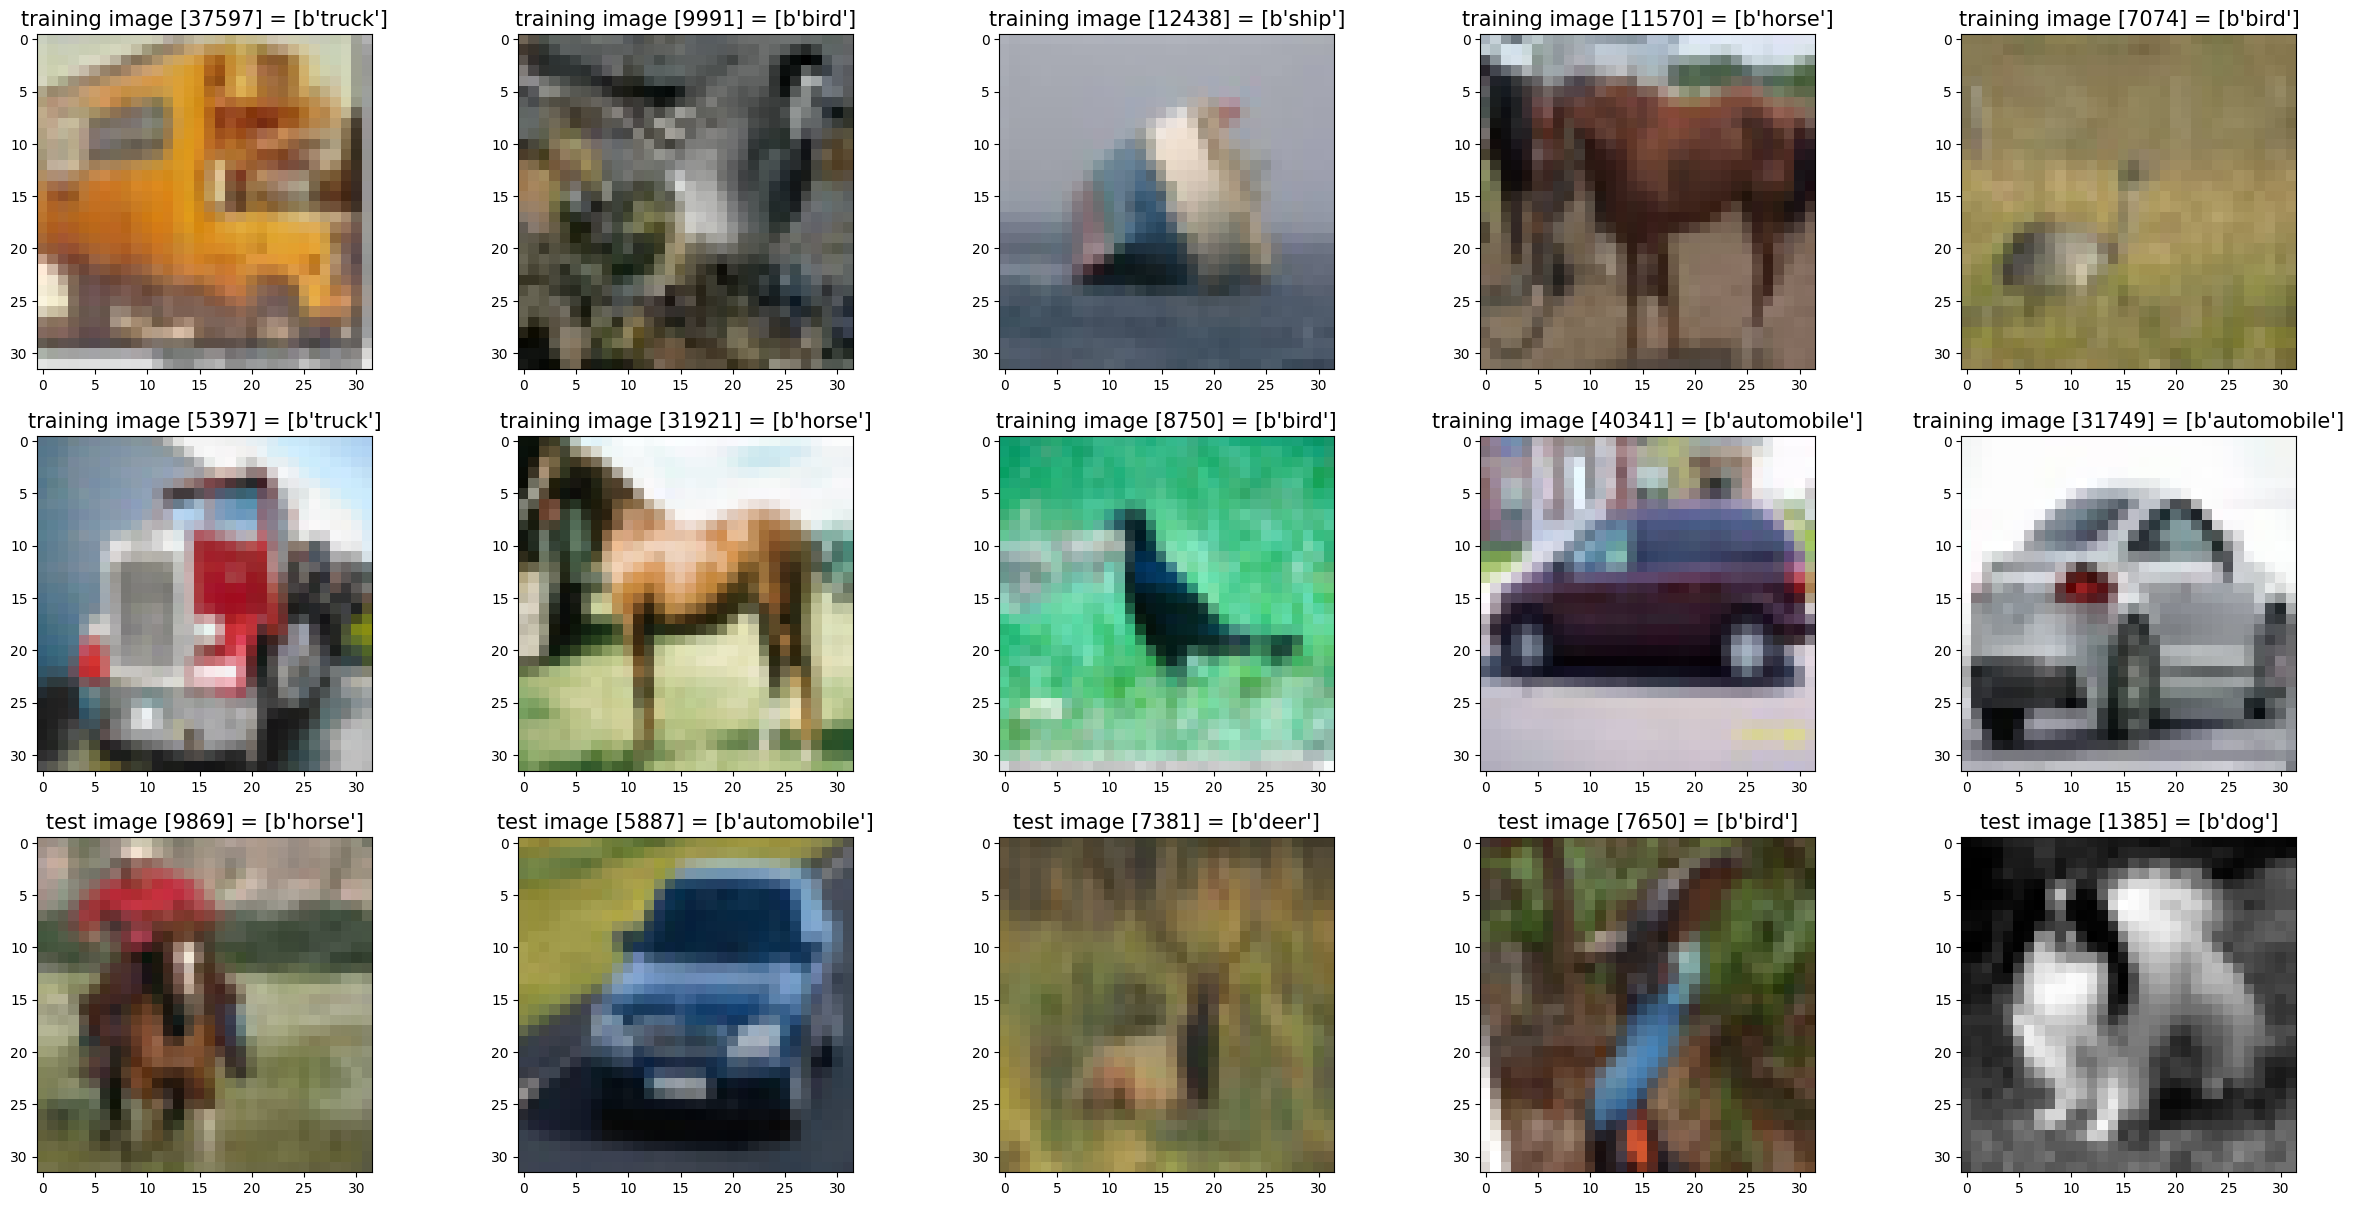

In [3]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 50000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(classes[y_train[r]]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(classes[y_test[r]]))

show_images(images_2_show, titles_2_show)


In [4]:
print("Available Physical Devices: ", tf.config.list_physical_devices())

Available Physical Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
LEARNING_RATE = 3e-4
DROPOUT_RATE = 0.3
REGULARIZATION = 1e-3

with tf.device('/GPU:0'):
    alexnet = tf.keras.Sequential(layers=[
        tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.Resizing(height=64, width=64),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4, 4), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=2048, activation='relu'),
        tf.keras.layers.Dropout(rate=DROPOUT_RATE),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dropout(rate=DROPOUT_RATE),
        tf.keras.layers.Dense(units=10)
    ])

alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                                                                                decay_steps=1000, decay_rate=0.95)),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 resizing_1 (Resizing)       (None, 64, 64, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_rotation_1 (RandomR  (None, 64, 64, 3)         0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       46592     
                                                      

In [9]:
checkpoint_filepath = './model_checkpoint'

history = alexnet.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_split=0.25, callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                                                                                             save_weights_only=True,
                                                                                                                                             monitor='val_sparse_categorical_accuracy',
                                                                                                                                             mode='max',
                                                                                                                                             save_best_only=True)])

alexnet.load_weights(checkpoint_filepath)

Epoch 1/100
293/293 [==============================] - 12s 23ms/step - loss: 2.9314 - sparse_categorical_accuracy: 0.3379 - val_loss: 4.2274 - val_sparse_categorical_accuracy: 0.1280
Epoch 2/100
293/293 [==============================] - 11s 39ms/step - loss: 2.5347 - sparse_categorical_accuracy: 0.4307 - val_loss: 2.7230 - val_sparse_categorical_accuracy: 0.3706
Epoch 3/100
293/293 [==============================] - 8s 27ms/step - loss: 2.2842 - sparse_categorical_accuracy: 0.4798 - val_loss: 2.3901 - val_sparse_categorical_accuracy: 0.4319
Epoch 4/100
293/293 [==============================] - 6s 21ms/step - loss: 2.0942 - sparse_categorical_accuracy: 0.5157 - val_loss: 2.0842 - val_sparse_categorical_accuracy: 0.4998
Epoch 5/100
293/293 [==============================] - 7s 23ms/step - loss: 1.9369 - sparse_categorical_accuracy: 0.5355 - val_loss: 1.9056 - val_sparse_categorical_accuracy: 0.5340
Epoch 6/100
293/293 [==============================] - 6s 21ms/step - loss: 1.8070 - spa

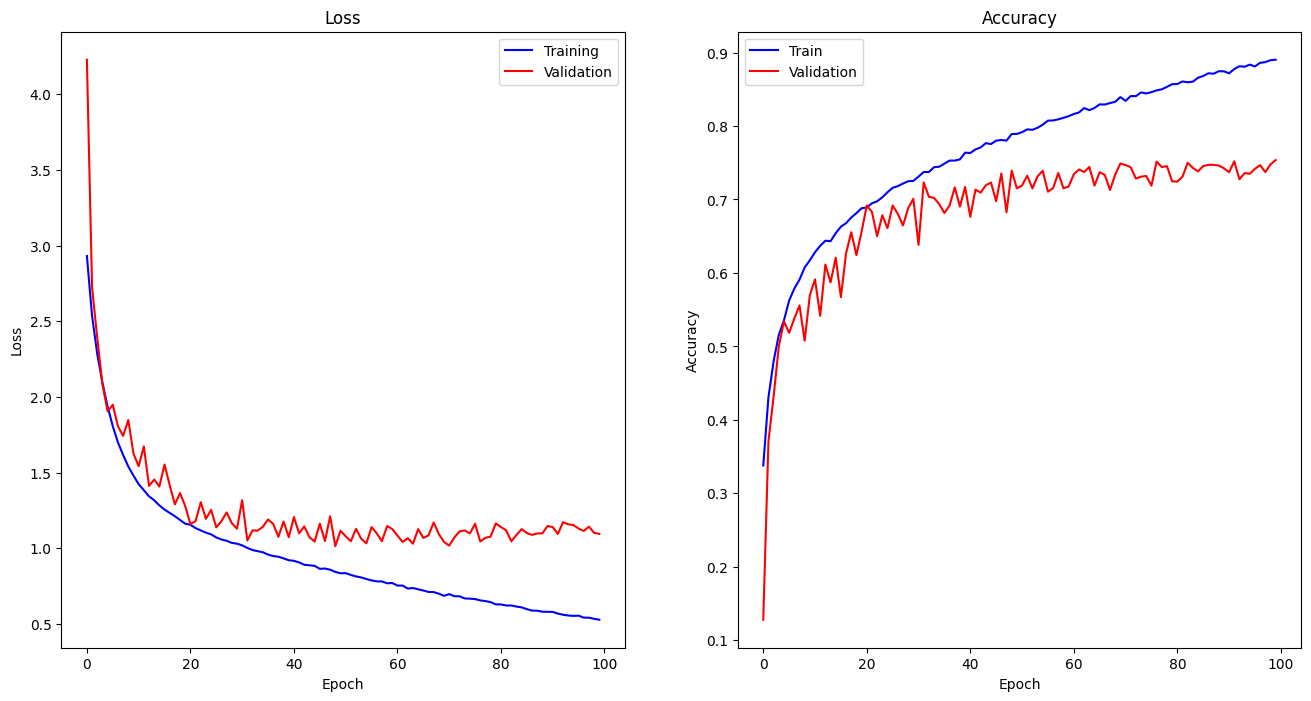

In [10]:
figure, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(history.history['loss'], color='b')
axes[0].plot(history.history['val_loss'], color='r')
axes[0].set_title('Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='upper right')

axes[1].plot(history.history['sparse_categorical_accuracy'], color='b')
axes[1].plot(history.history['val_sparse_categorical_accuracy'], color='r')
axes[1].set_title('Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [18]:
accuracy = alexnet.evaluate(x=x_test, y=y_test)[-1]*100
accuracy = accuracy - ((accuracy*100)%1)/100

print('\n\n\tAccuracy:\t', accuracy, '%')

313/313 [==============================] - 2s 5ms/step - loss: 1.1125 - sparse_categorical_accuracy: 0.7518


	Accuracy:	 75.18 %


In [19]:
y_test_pred_scores = alexnet.predict(x_test)
y_test_pred = np.argmax(y_test_pred_scores, axis=-1)

313/313 [==============================] - 1s 3ms/step


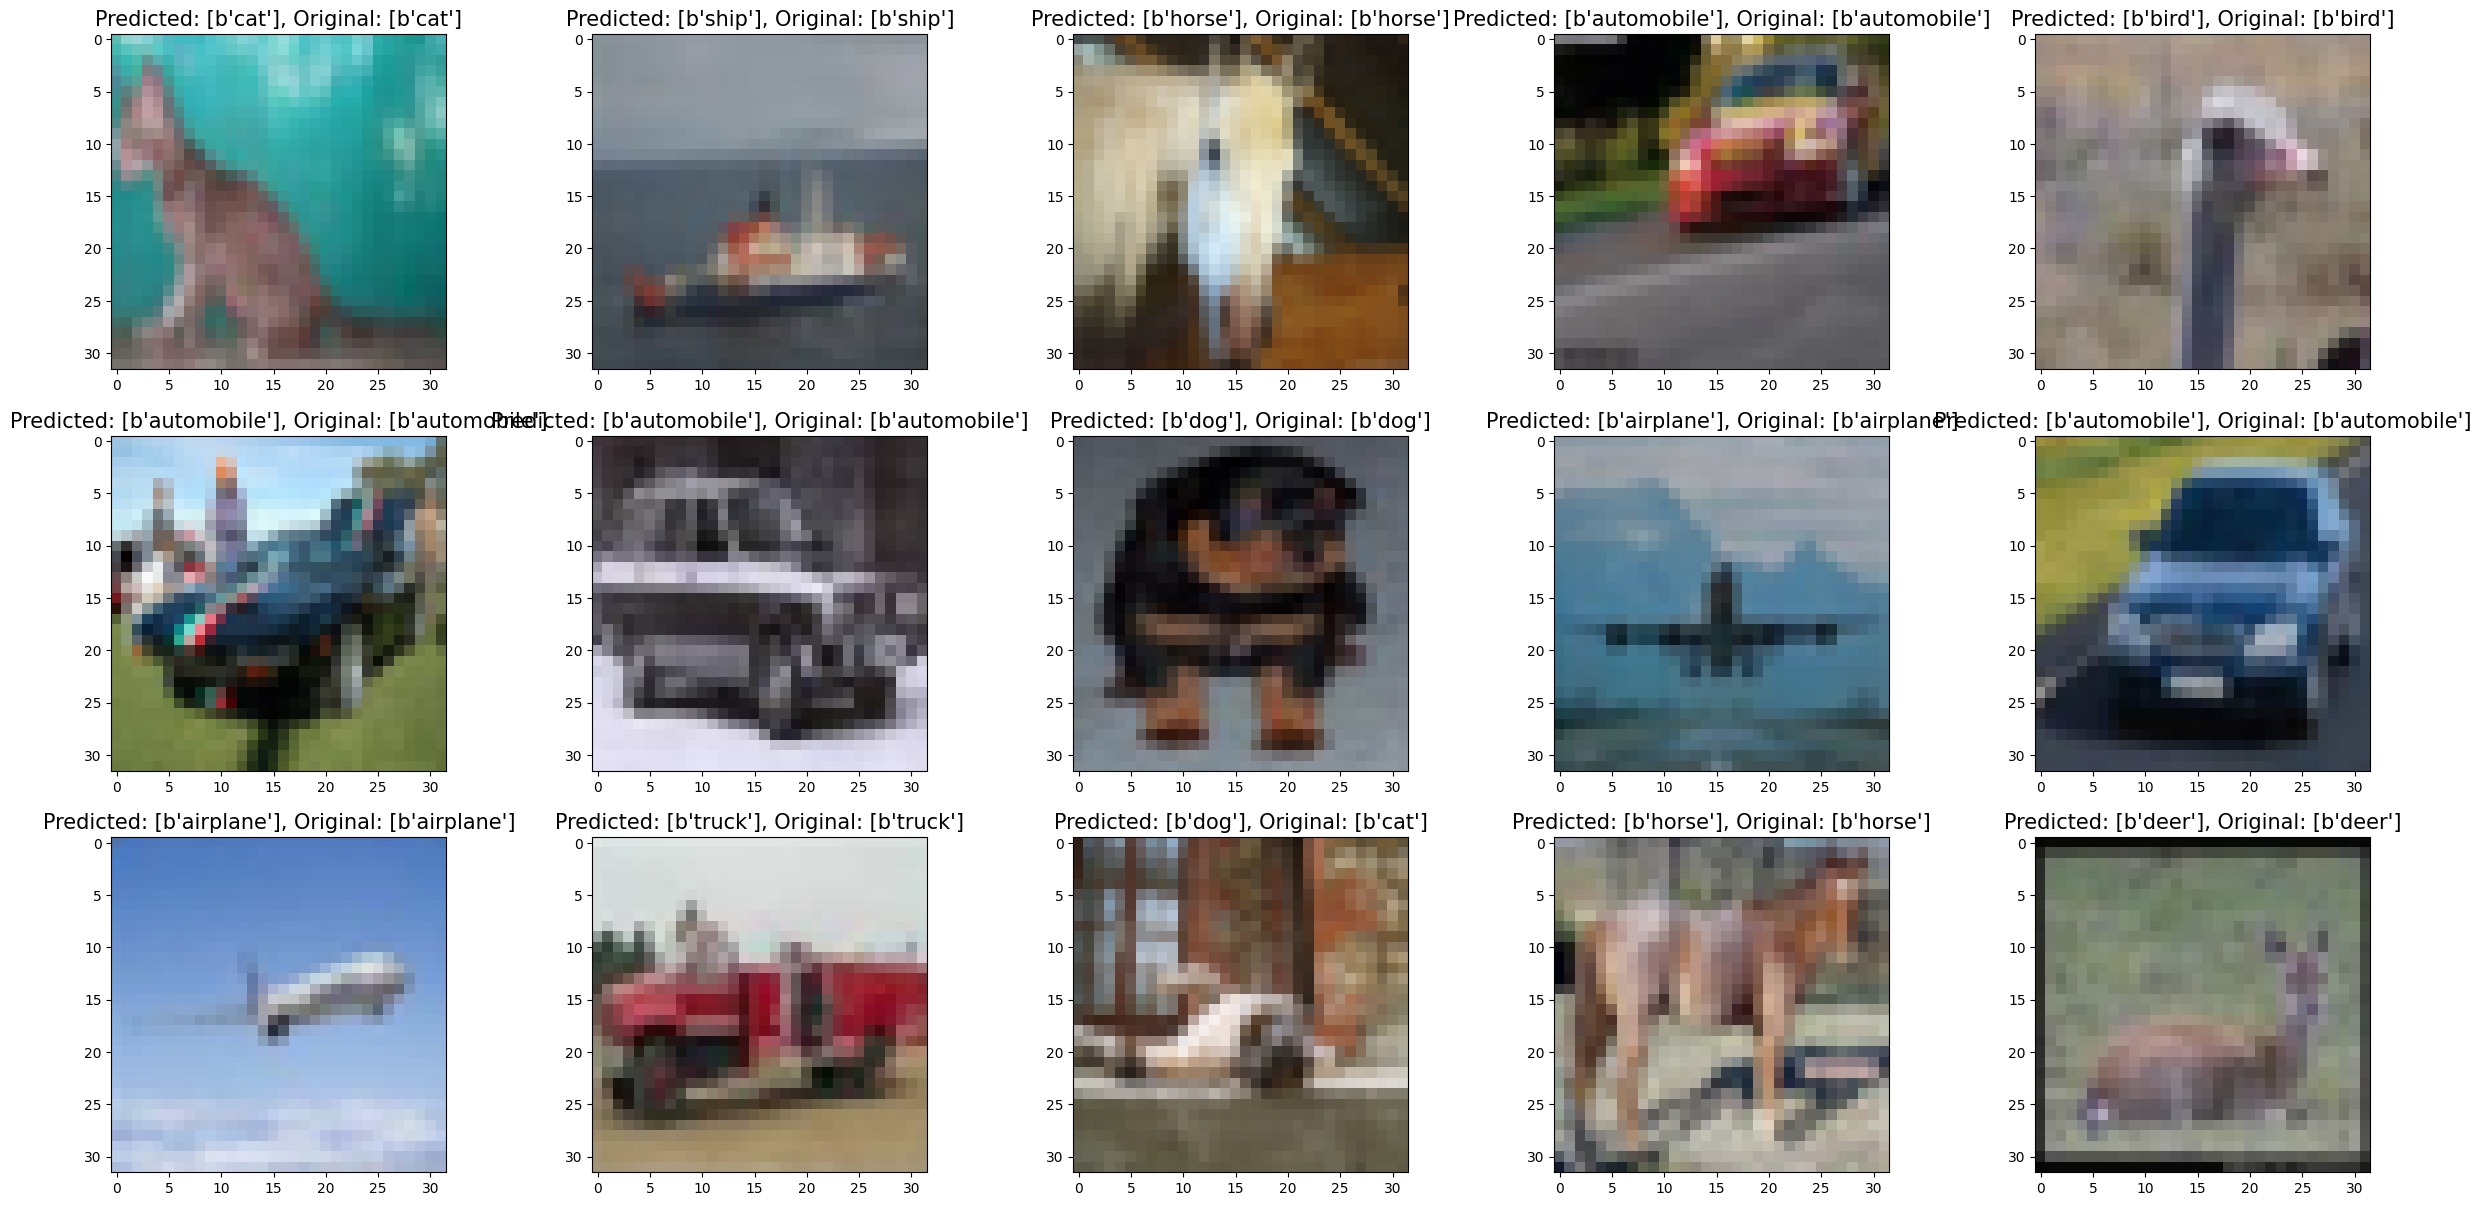

In [13]:
images_2_show = []
titles_2_show = []
for i in range(0, 15):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('Predicted: [' + str(classes[y_test_pred[r]]) + '], Original: ' + str(classes[y_test[r]]))

show_images(images_2_show, titles_2_show)

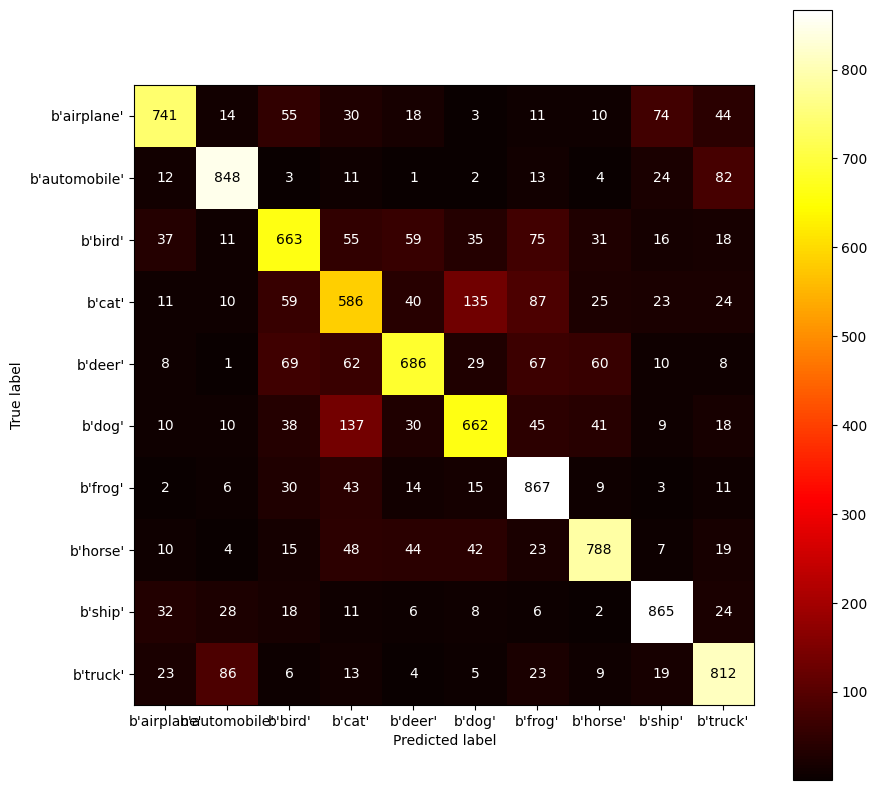

In [14]:
cnf = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cnf, cmap='hot', interpolation='nearest')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.xticks(np.arange(10), classes)
plt.yticks(np.arange(10), classes)

for i in range(10):
    for j in range(10):
        if i == j:
            plt.text(j, i, cnf[i, j], ha='center', va='center', color='black')
        else:
            plt.text(j, i, cnf[i, j], ha='center', va='center', color='white')

plt.show()

In [23]:
y_softmax = np.exp(y_test_pred_scores) / np.sum(np.exp(y_test_pred_scores), axis=1, keepdims=True)
auc = roc_auc_score(y_test, y_softmax, average='weighted', multi_class='ovr')

print('\n\n\tROC AUC:\t', auc)



	ROC AUC:	 0.9663003666666667


In [15]:
alexnet.save('../content/AlexNet.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(alexnet)
tflite_model = converter.convert()
open("AlexNet.tflite", "wb").write(tflite_model)

18549740